# Predicción de Cáncer de Mama Usando LogisticRegression
## Caso de Negocio
El objetivo de este proyecto es desarrollar un modelo predictivo que ayude en el diagnóstico del cáncer de mama, identificando las características más relevantes que contribuyen a una clasificación precisa.

### Objetivos Principales:
1. **Reducción de Costos**: Minimizar los costos de las pruebas diagnósticas enfocándose en las características más impactantes.
2. **Eficiencia**: Simplificar el proceso de diagnóstico sin comprometer la precisión.
3. **Escalabilidad**: Crear un modelo ligero e interpretable que pueda utilizarse en distintos entornos de atención médica.


## Descripción del Dataset
El dataset consiste en mediciones obtenidas a partir de imágenes digitalizadas de aspiraciones con aguja fina de masas mamarias. Cada fila representa una única muestra, y las características incluyen propiedades como `radius`, `texture`, `area`, entre otras, calculadas como `mean`, `se` y `worst`.

### Variable Objetivo:
- **Diagnosis**: Clasificación binaria:
  - `M` = Maligno  
  - `B` = Benigno


### Importar datos y librerias necesarias

In [1]:
%pip install -q lightgbm

In [22]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore') # suppress uneccessary python warnings

# Load Dataset
cancer = pd.read_csv('/breast.csv')

In [3]:
#imprimimos ciertas lineas
cancer.head()

,ID,Diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Rename Columns
new_columns = ['ID', 'Diagnosis']
for i in range(30):
    column_name = cancer.columns[i + 2]
    suffix = 'mean' if column_name.endswith('1') else 'se' if column_name.endswith('2') else 'worst'
    new_columns.append(column_name[:-1] + '_' + suffix)
cancer.columns = new_columns


     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     compactness_mean  concavity_mean  concave_points_mean  sym

In [8]:
# Prepare Features and Target
X = cancer.drop(columns=['ID', 'Diagnosis'])  # Drop ID and target
y = (cancer['Diagnosis'] == 'M').astype(int)  # Binary encoding: 1 for Malignant, 0 for Benign

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Balance the Training Set Using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

### Mostrar resultados luego de balancear los datos

In [9]:
# Before SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# After SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Class distribution before SMOTE:
Diagnosis
0    267
1    159
Name: count, dtype: int64

Class distribution after SMOTE:
Diagnosis
0    267
1    267
Name: count, dtype: int64


In [10]:
# Definir la grilla de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' permite usar tanto L1 como L2
}

# Crear el modelo base
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Usar GridSearchCV para encontrar los mejores parámetros
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Mostrar los mejores parámetros y el mejor score
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor AUC promedio en validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores parámetros encontrados: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor AUC promedio en validación cruzada: 0.9967116279683029


                 Feature  Coefficient  Abs_Coefficient
27  concave_points_worst    25.072082        25.072082
7    concave_points_mean    21.335952        21.335952
28        symmetry_worst     7.650108         7.650108
6         concavity_mean     7.043053         7.043053
11            texture_se    -3.991007         3.991007
24      smoothness_worst     2.204454         2.204454
12          perimeter_se     1.122114         1.122114
0            radius_mean    -0.976684         0.976684
21         texture_worst     0.726441         0.726441
1           texture_mean    -0.227821         0.227821


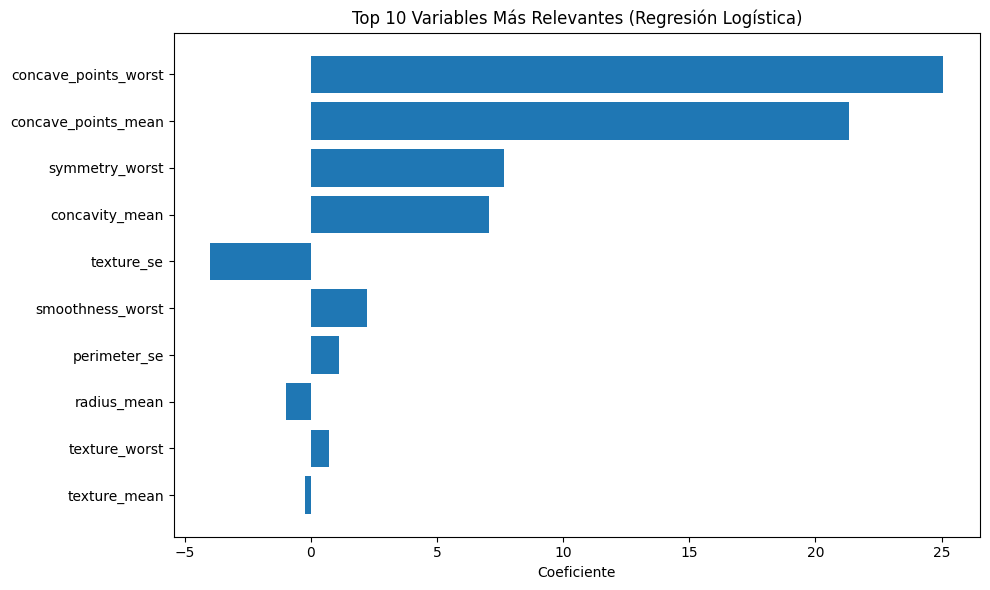

In [15]:
# Obtener el mejor modelo
best_logreg = grid_search.best_estimator_

# Obtener coeficientes y nombres de las variables ( hay un coeficiente por cada feature)
coefficients = best_logreg.coef_[0]
features = X.columns

# Crear un DataFrame ordenado
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar las variables más importantes
print(coef_df.head(10))

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:10][::-1], coef_df['Coefficient'][:10][::-1])
plt.xlabel("Coeficiente")
plt.title("Top 10 Variables Más Relevantes (Regresión Logística)")
plt.tight_layout()
plt.show()

In [18]:
# Obtener los mejores parámetros encontrados por GridSearchCV
best_params = grid_search.best_params_

# Crear un modelo con esos mejores parámetros
best_logreg = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    random_state=42,
    max_iter=1000
)

# Entrenar el modelo con los datos balanceados
best_logreg.fit(X_train_balanced, y_train_balanced)

# Ahora puedes usar este modelo para predecir en X_test
y_pred = best_logreg.predict(X_test)
y_pred_proba = best_logreg.predict_proba(X_test)[:,1]  # Probabilidades clase 1

# Evaluar, por ejemplo con AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC en test: {auc:.4f}")

# Reporte de clasificación
print(classification_report(y_test, y_pred))


AUC en test: 0.9962
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        90
           1       0.96      0.92      0.94        53

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



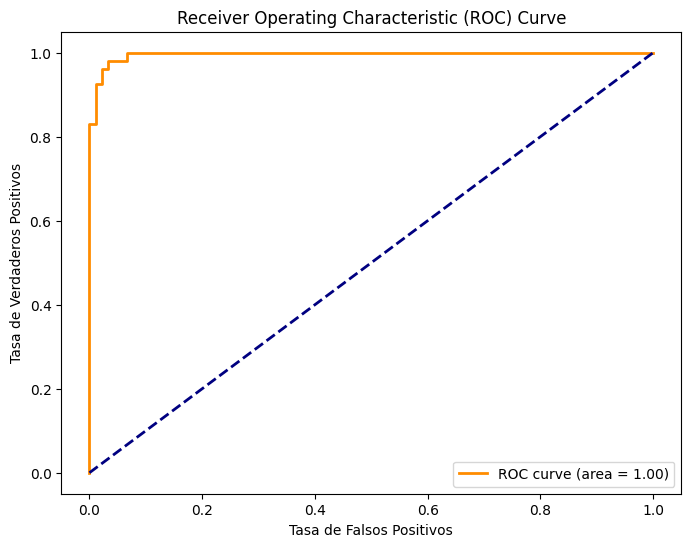

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Conclusiones

- Se logró construir un modelo de regresión logística para la clasificación binaria de cáncer maligno vs benigno, utilizando datos balanceados con SMOTE para corregir el desbalance de clases en el conjunto de entrenamiento.

- La búsqueda de hiperparámetros mediante GridSearchCV permitió optimizar parámetros clave (`C`, `penalty`, `solver`), mejorando la capacidad predictiva del modelo.

- El modelo final presenta un desempeño excelente en el conjunto de prueba, con un **AUC de 0.996**, lo que indica una muy alta capacidad para distinguir entre casos malignos y benignos.

- Las métricas de precisión, recall y F1-score también son altas para ambas clases, destacando un **recall del 92% para la clase maligno**, lo que significa que el modelo detecta correctamente la mayoría de los casos malignos, minimizando falsos negativos.

- El uso de regresión logística facilita la interpretabilidad, permitiendo identificar las variables con mayor influencia en la predicción, aspecto fundamental en aplicaciones médicas donde la transparencia es clave.

- Como próximo paso, se recomienda explorar modelos que capturen relaciones no lineales para potencialmente mejorar la sensibilidad sin perder interpretabilidad.
